# Aprendizaje Profundo: Práctico

En este práctico trabajaremos en el problema de clasificación de texto del MeLi Challenge 2019.
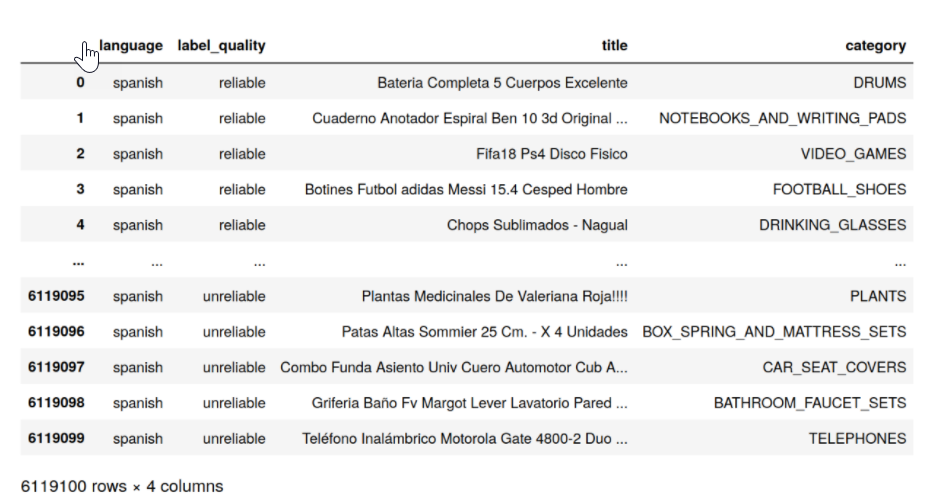

El datasets tiene información acerca de títulos de publicaciones, categoría de los mismos, información de idioma y confiabilidad de la anotación. Cuenta con anotaciones de títulos para 632 categorías distintas.
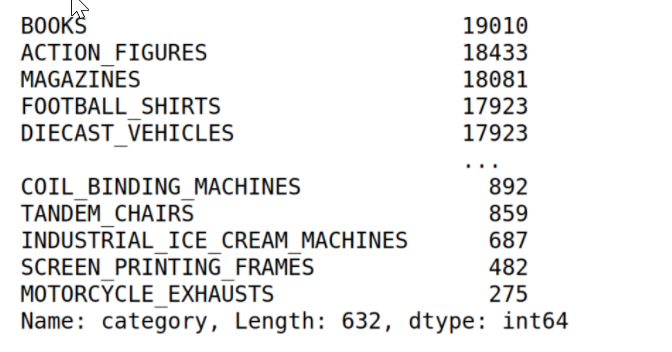

El dataset también cuenta con una partición de test que está compuesta de 63680 de ejemplos con las mismas categorías (aunque no necesariamente la misma distribución).

También hay datos en idioma portugues, aunque para el práctico de esta materia basta con usar uno solo de los idiomas.
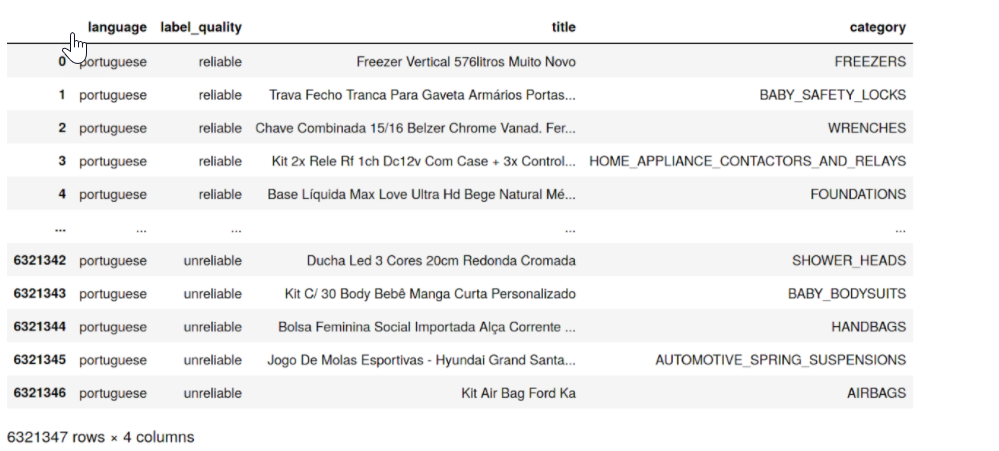

### Ejercicio

Implementar una red neuronal que asigne una categoría dado un título. Para este práctico se puede usar cualquier tipo de red neuronal. Les que hagan solo la primera mitad de la materia, implementarán un MLP. Quienes cursan la materia completa, deberían implementar algo más complejo, usando CNNs, RNNs o Transformers.

Algunas consideraciones a tener en cuenta para estructurar el trabajo:

Hacer un preprocesamiento de los datos (¿Cómo vamos a representar los datos de entrada y las categorías?).
Tener un manejador del dataset (alguna clase o función que nos divida los datos en batches).
Crear una clase para el modelo que se pueda instanciar con diferentes hiperparámetros
Hacer logs de entrenamiento (reportar tiempo transcurrido, iteraciones/s, loss, accuracy, etc.). Usar MLFlow.
Hacer un gráfico de la función de loss a lo largo de las epochs. MLFlow también puede generar la gráfica.
Reportar performance en el conjunto de test con el mejor modelo entrenado. La métrica para reportar será balanced accuracy (Macro-recall).

#### Importar desde Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Instalar mflow y gensim

In [6]:
!pip install mlflow
!pip install gensim==4.1.2

#### Importar librerias

In [7]:
import csv
import mlflow
import functools
import gzip
import numpy as np
import pandas as pd
import torch
import tempfile
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn 
from sklearn.metrics import average_precision_score
from time import time
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from gensim import corpora

import torch.nn.functional as F
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from gensim.parsing import preprocessing
from torch.utils.data import Dataset, DataLoader, IterableDataset
from tqdm import tqdm, trange
from sklearn.metrics import balanced_accuracy_score

#### Importar train

In [8]:
data = pd.read_csv("/content/drive/MyDrive/DeepLearning/train.csv", nrows= 100000) 

data = data[data['language']=='spanish']
data.shape

(50043, 4)

In [9]:
n_labels = data.groupby(['category'])

n_labels=len(n_labels)

#### Transformar datos

In [10]:
class MeLiChallengeDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.tolist()  # Deal with list of items instead of tensor
        
        item = {
                    "data": self.dataset.iloc[item]["title"],
                    "target": self.dataset.iloc[item]["category"]                    
                }

        if self.transform:
            item = self.transform(item)
        
        return item

#### Procesar datos

In [11]:
class TextPreprocess:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        self.dictionary = corpora.Dictionary(
            dataset["title"].map(self._preprocess_string).tolist())
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        self.dictionary.compactify()

        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })

        self.idx_to_target = sorted(dataset["category"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}
        
    def _preprocess_string(self, string):
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)

    def encode_target(self, target): 
       return self.target_to_idx[target]

    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))

    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
      
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
    
        return {
            "data": data,
            "target": target
        }

In [12]:
preprocess = TextPreprocess(data)

#### Definir train y test

In [13]:
train_indices, test_indices = train_test_split(data.index, test_size=0.2, random_state=42)
train_dataset = MeLiChallengeDataset(data.loc[train_indices].reset_index(drop=True), transform=preprocess)
test_dataset = MeLiChallengeDataset(data.loc[test_indices].reset_index(drop=True), transform=preprocess)

In [14]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=None, min_length=1):
        assert max_length is None or min_length <= max_length
        self.pad_value = pad_value
        self.max_length = max_length
        self.min_length = min_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        if self.max_length:
            max_length = self.max_length
            seq_lengths = [min(self.max_length, l) for l in seq_lengths]
        else:
            max_length = max(self.min_length, max(seq_lengths))

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
        return {
            "data": torch.LongTensor(data),
            "target": torch.LongTensor(target)
        }

In [15]:
FILTERS_COUNT = 150
FILTERS_LENGTH = [2, 3, 4]

pad_sequences = PadSequences(min_length=max(FILTERS_LENGTH))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False)

#### Definir red

In [16]:
class MELI_Categories_Classifier(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 hidden_layers,epochs,batch_size,freeze_embedings,filters_count,filters_length,
                 dropout,learning_rate,weight_decay):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.convs = []
        for filter_lenght in FILTERS_LENGTH:
            self.convs.append(
                nn.Conv1d(vector_size, FILTERS_COUNT, filter_lenght)
            )
        self.convs = nn.ModuleList(self.convs)
        self.fc = nn.Linear(FILTERS_COUNT * len(FILTERS_LENGTH), 128)
        self.output = nn.Linear(128, n_labels)
        self.vector_size = vector_size

    @staticmethod
    def conv_global_max_pool(x, conv):
        return F.relu(conv(x).transpose(1, 2).max(1)[0])
    
    def forward(self, x):
        x = self.embeddings(x).transpose(1, 2)  # Conv1d takes (batch, channel, seq_len)
        x = [self.conv_global_max_pool(x, conv) for conv in self.convs]
        x = torch.cat(x, dim=1)
        x = F.relu(self.fc(x))
        x = self.output(x)
        return x

#### Entrenar red con hiperparámetros por default

In [17]:
epocas=10
lr=0.001
wd=1e-5

mlflow.set_experiment("a_naive_experiment")
historical_loss_test = []
historical_loss_train = []

with mlflow.start_run():
    mlflow.log_param("model_name", "cnn")
    mlflow.log_param("freeze_embedding", True)
    mlflow.log_params({
        "filters_count": FILTERS_COUNT,
        "filters_length": FILTERS_LENGTH,
        "fc_size": 128
    })
    model = MELI_Categories_Classifier("/content/drive/MyDrive/DeepLearning/glove.6B.50d.txt", 
    preprocess.dictionary, 50, 1,epocas,128,True,FILTERS_COUNT,FILTERS_LENGTH,0,lr,wd)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)


    
    for epoch in trange(epocas):
        start = time()
        model.train()
        running_loss = []
        for idx, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            output = model(batch["data"])
            loss_value = loss(output, batch["target"])
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        print("Epoch %03d, Time taken %.2f, Testing-Loss %.5f" % (epoch, time()-start, sum(running_loss) / len(running_loss)))
        historical_loss_test.append(sum(running_loss) / len(running_loss))

        model.eval()
        running_loss = []
        balanced_accuracy = []
        targets = []
        predictions = []
        for batch in tqdm(test_loader):
            output = model(batch["data"])
            running_loss.append(
                loss(output, batch["target"]).item()
            )
            targets.extend(batch["target"].numpy())
            predictions.extend(output.squeeze().detach().numpy())
        mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric('test_bacc', balanced_accuracy_score(targets, np.argmax(predictions, axis=1)), epoch)
        balanced_accuracy.append(balanced_accuracy_score(targets, np.argmax(predictions, axis=1)))

        print("Epoch %03d, Time taken %.2f, Testing-Loss %.5f" % (epoch, time()-start, sum(running_loss) / len(running_loss)))
        historical_loss_train.append(sum(running_loss) / len(running_loss))
    
    with tempfile.TemporaryDirectory() as tmpdirname:
        targets = []
        predictions = []
        for batch in tqdm(test_loader):
            output = model(batch["data"])
            targets.extend(batch["target"].numpy())
            predictions.extend(output.squeeze().detach().numpy())
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False
        )
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")

100%|██████████| 313/313 [00:22<00:00, 13.96it/s]


Epoch 000, Time taken 22.45, Testing-Loss 6.86176



 10%|█         | 1/10 [00:26<04:00, 26.72s/it]

Epoch 000, Time taken 26.72, Testing-Loss 6.35287



100%|██████████| 313/313 [00:21<00:00, 14.52it/s]


Epoch 001, Time taken 21.57, Testing-Loss 5.57863



100%|██████████| 79/79 [00:04<00:00, 19.44it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 20%|██        | 2/10 [00:52<03:29, 26.16s/it]

Epoch 001, Time taken 25.77, Testing-Loss 5.07906



100%|██████████| 313/313 [00:21<00:00, 14.43it/s]


Epoch 002, Time taken 21.71, Testing-Loss 4.27145



100%|██████████| 79/79 [00:04<00:00, 19.58it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 30%|███       | 3/10 [01:18<03:02, 26.04s/it]

Epoch 002, Time taken 25.88, Testing-Loss 4.31494



100%|██████████| 313/313 [00:21<00:00, 14.50it/s]


Epoch 003, Time taken 21.60, Testing-Loss 3.46197



100%|██████████| 79/79 [00:04<00:00, 19.32it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 40%|████      | 4/10 [01:44<02:35, 25.96s/it]

Epoch 003, Time taken 25.83, Testing-Loss 3.98455



100%|██████████| 313/313 [00:23<00:00, 13.19it/s]


Epoch 004, Time taken 23.77, Testing-Loss 2.95127



100%|██████████| 79/79 [00:04<00:00, 19.19it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 50%|█████     | 5/10 [02:12<02:13, 26.70s/it]

Epoch 004, Time taken 28.02, Testing-Loss 3.75276



100%|██████████| 313/313 [00:31<00:00,  9.79it/s]


Epoch 005, Time taken 31.99, Testing-Loss 2.58178



100%|██████████| 79/79 [00:04<00:00, 18.78it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 60%|██████    | 6/10 [02:48<01:59, 29.98s/it]

Epoch 005, Time taken 36.34, Testing-Loss 3.64587



100%|██████████| 313/313 [00:37<00:00,  8.27it/s]


Epoch 006, Time taken 37.88, Testing-Loss 2.29062



100%|██████████| 79/79 [00:04<00:00, 18.98it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 70%|███████   | 7/10 [03:30<01:41, 33.97s/it]

Epoch 006, Time taken 42.19, Testing-Loss 3.60638



100%|██████████| 313/313 [00:38<00:00,  8.09it/s]


Epoch 007, Time taken 38.70, Testing-Loss 2.05747



100%|██████████| 79/79 [00:04<00:00, 18.35it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 80%|████████  | 8/10 [04:13<01:13, 36.89s/it]

Epoch 007, Time taken 43.14, Testing-Loss 3.58105



100%|██████████| 313/313 [00:39<00:00,  7.86it/s]


Epoch 008, Time taken 39.87, Testing-Loss 1.86109



100%|██████████| 79/79 [00:04<00:00, 18.40it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 90%|█████████ | 9/10 [04:58<00:39, 39.21s/it]

Epoch 008, Time taken 44.30, Testing-Loss 3.60311



100%|██████████| 313/313 [00:35<00:00,  8.86it/s]


Epoch 009, Time taken 35.34, Testing-Loss 1.69461



100%|██████████| 79/79 [00:04<00:00, 18.13it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
100%|██████████| 10/10 [05:38<00:00, 33.80s/it]


Epoch 009, Time taken 39.83, Testing-Loss 3.59718


100%|██████████| 79/79 [00:03<00:00, 21.00it/s]


#### Resultados para red con hiperparámetros por default

###### Métrica Test_bacc

In [18]:
balanced_accuracy

[0.3419090804659704]

###### Métrica Test_loss

In [19]:
historical_loss_test

[6.861758495672062,
 5.578628046444049,
 4.271452849665389,
 3.461967650312966,
 2.9512698993134423,
 2.5817760053914958,
 2.29062026224959,
 2.0574749788156335,
 1.8610946370389896,
 1.6946088641215438]

###### Métrica Train_loss

In [20]:
historical_loss_train

[6.352873470209822,
 5.079060723509969,
 4.3149429212642625,
 3.9845522838302805,
 3.7527606215658067,
 3.6458696443823317,
 3.6063772424866882,
 3.5810501032237765,
 3.603106387053864,
 3.5971767932553833]

###### Predicciones

Se muestran a continuación una serie pequeña de resultados de las predicciones

In [21]:
np.argmax(predictions, axis=1)

array([ 100, 1061,  666, ..., 1522,  602,  793])

In [22]:
columnas = ['Predictions'] 
df = pd.DataFrame(np.argmax(predictions, axis=1), columns=columnas)
df['Targets'] = targets

print(df)

       Predictions  Targets
0              100      100
1             1061      458
2              666      107
3              940       92
4              161      249
...            ...      ...
10004          626      626
10005          930      930
10006         1522      329
10007          602      838
10008          793      793

[10009 rows x 2 columns]


###### Conclusiones

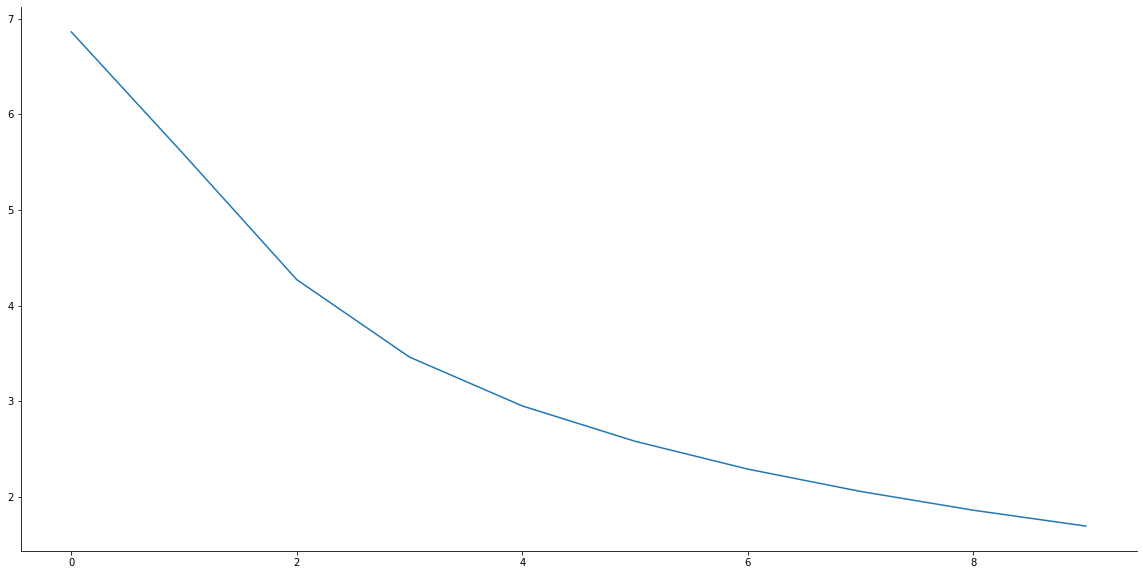

In [23]:
plt.figure(figsize=(20,10))
seaborn.lineplot(x=range(len(historical_loss_test)), y=historical_loss_test)
seaborn.despine()

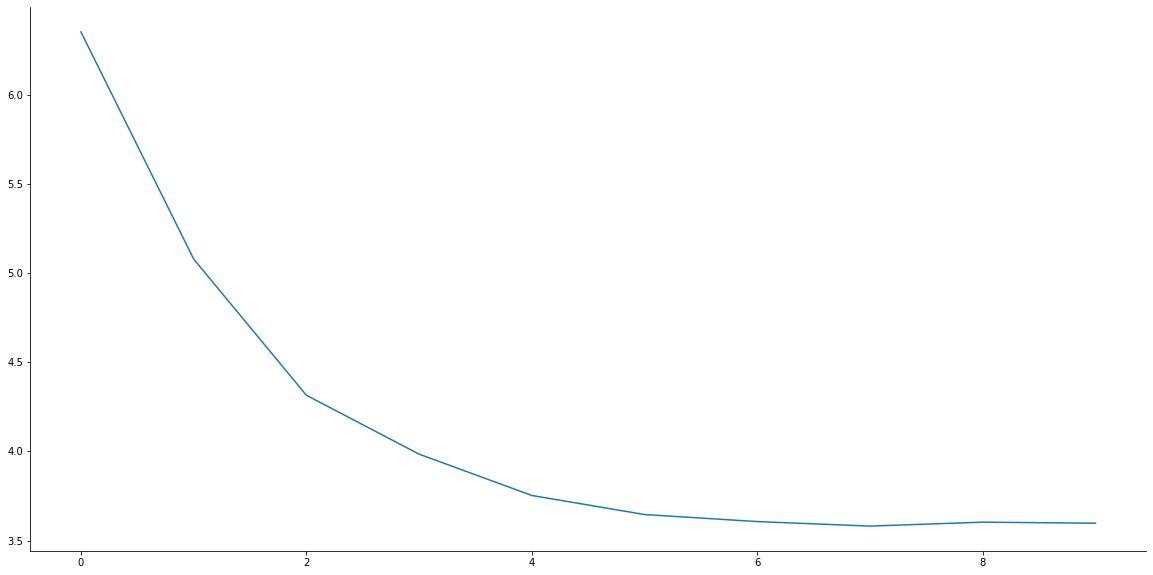

In [24]:
plt.figure(figsize=(20,10))
seaborn.lineplot(x=range(len(historical_loss_train)), y=historical_loss_train)
seaborn.despine()

#### Entrenando la red con optimización manual de hiperparámetros

In [26]:
class MELI_Categories_Classifier_Optimized(nn.Module):
    def __init__(self, 
                 pretrained_embeddings_path, 
                 dictionary,
                 vector_size,
                 hidden_layers,epochs,batch_size,freeze_embedings,filters_count,filters_length,
                 dropout,learning_rate,weight_decay):
        super().__init__()
        embeddings_matrix = torch.randn(len(dictionary), vector_size)
        embeddings_matrix[0] = torch.zeros(vector_size)
        with open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embeddings = nn.Embedding.from_pretrained(embeddings_matrix,
                                                       freeze=freeze_embedings,
                                                       padding_idx=0)
        self.convs = []
        for filter_lenght in FILTERS_LENGTH:
            self.convs.append(
                nn.Conv1d(vector_size, FILTERS_COUNT, filter_lenght)
            )
        self.convs = nn.ModuleList(self.convs)
        self.fc = nn.Linear(FILTERS_COUNT * len(FILTERS_LENGTH), 128)
        self.output = nn.Linear(128, n_labels)
        self.vector_size = vector_size

    @staticmethod
    def conv_global_max_pool(x, conv):
        return F.relu(conv(x).transpose(1, 2).max(1)[0])
    
    def forward(self, x):
        x = self.embeddings(x).transpose(1, 2)  # Conv1d takes (batch, channel, seq_len)
        x = [self.conv_global_max_pool(x, conv) for conv in self.convs]
        x = torch.cat(x, dim=1)
        x = F.relu(self.fc(x))
        x = self.output(x)
        return x

In [27]:
ep=10
lr=1e-3
wd=1e-5
mlflow.set_experiment("a_naive_experiment")
historical_loss_test_hip = []
historical_loss_train_hip = []

with mlflow.start_run():
    mlflow.log_param("model_name", "cnn")
    mlflow.log_param("freeze_embedding", False)
    mlflow.log_params({
        "filters_count": FILTERS_COUNT,
        "filters_length": FILTERS_LENGTH,
        "fc_size": 128
    })
    model = MELI_Categories_Classifier_Optimized("/content/drive/MyDrive/DeepLearning/glove.6B.50d.txt", 
                                                       preprocess.dictionary, 50,hidden_layers=1,epochs=ep,
                                                       batch_size=128,freeze_embedings=False,
                                                       filters_count=FILTERS_COUNT,filters_length=FILTERS_LENGTH,
                                                       dropout=0,learning_rate=lr,weight_decay=wd)
    loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    
    
    
    for epoch in trange(ep):
        start = time()
        model.train()
        running_loss = []
        for idx, batch in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            output = model(batch["data"])
            loss_value = loss(output, batch["target"])
            loss_value.backward()
            optimizer.step()
            running_loss.append(loss_value.item())        
        mlflow.log_metric("train_loss", sum(running_loss) / len(running_loss), epoch)
        print("Epoch %03d, Time taken %.2f, Testing-Loss %.5f" % (epoch, time()-start, sum(running_loss) / len(running_loss)))
        historical_loss_test_hip.append(sum(running_loss) / len(running_loss))

        model.eval()
        running_loss = []
        balanced_accuracy_hip = []
        targets = []
        predictions = []
        for batch in tqdm(test_loader):
            output = model(batch["data"])
            running_loss.append(
                loss(output, batch["target"]).item()
            )
            targets.extend(batch["target"].numpy())
            predictions.extend(output.squeeze().detach().numpy())
        mlflow.log_metric("test_loss", sum(running_loss) / len(running_loss), epoch)
        mlflow.log_metric('test_bacc', balanced_accuracy_score(targets, np.argmax(predictions, axis=1)), epoch)
        balanced_accuracy_hip.append(balanced_accuracy_score(targets, np.argmax(predictions, axis=1)))

        print("Epoch %03d, Time taken %.2f, Testing-Loss %.5f" % (epoch, time()-start, sum(running_loss) / len(running_loss)))
        historical_loss_train_hip.append(sum(running_loss) / len(running_loss))
    
    with tempfile.TemporaryDirectory() as tmpdirname:
        targets = []
        predictions = []
        for batch in tqdm(test_loader):
            output = model(batch["data"])
            targets.extend(batch["target"].numpy())
            predictions.extend(output.squeeze().detach().numpy())
        pd.DataFrame({"prediction": predictions, "target": targets}).to_csv(
            f"{tmpdirname}/predictions.csv.gz", index=False
        )
        mlflow.log_artifact(f"{tmpdirname}/predictions.csv.gz")

100%|██████████| 313/313 [00:26<00:00, 11.99it/s]


Epoch 000, Time taken 26.12, Testing-Loss 6.83366



 10%|█         | 1/10 [00:30<04:32, 30.26s/it]

Epoch 000, Time taken 30.26, Testing-Loss 6.24585



100%|██████████| 313/313 [00:25<00:00, 12.11it/s]


Epoch 001, Time taken 25.87, Testing-Loss 5.17647



100%|██████████| 79/79 [00:04<00:00, 19.67it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 20%|██        | 2/10 [01:00<04:01, 30.13s/it]

Epoch 001, Time taken 30.03, Testing-Loss 4.36571



100%|██████████| 313/313 [00:26<00:00, 11.92it/s]


Epoch 002, Time taken 26.29, Testing-Loss 3.37500



100%|██████████| 79/79 [00:04<00:00, 19.38it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 30%|███       | 3/10 [01:30<03:32, 30.30s/it]

Epoch 002, Time taken 30.50, Testing-Loss 3.33856



100%|██████████| 313/313 [00:26<00:00, 12.00it/s]


Epoch 003, Time taken 26.11, Testing-Loss 2.40518



100%|██████████| 79/79 [00:04<00:00, 19.46it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 40%|████      | 4/10 [02:01<03:01, 30.30s/it]

Epoch 003, Time taken 30.31, Testing-Loss 2.91298



100%|██████████| 313/313 [00:35<00:00,  8.83it/s]


Epoch 004, Time taken 35.48, Testing-Loss 1.82124



100%|██████████| 79/79 [00:04<00:00, 18.97it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 50%|█████     | 5/10 [02:40<02:48, 33.72s/it]

Epoch 004, Time taken 39.78, Testing-Loss 2.67765



100%|██████████| 313/313 [00:45<00:00,  6.83it/s]


Epoch 005, Time taken 45.82, Testing-Loss 1.41462



100%|██████████| 79/79 [00:04<00:00, 17.98it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 60%|██████    | 6/10 [03:31<02:37, 39.38s/it]

Epoch 005, Time taken 50.36, Testing-Loss 2.59472



100%|██████████| 313/313 [00:44<00:00,  7.01it/s]


Epoch 006, Time taken 44.66, Testing-Loss 1.10403



100%|██████████| 79/79 [00:04<00:00, 17.92it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 70%|███████   | 7/10 [04:20<02:07, 42.59s/it]

Epoch 006, Time taken 49.21, Testing-Loss 2.58078



100%|██████████| 313/313 [00:42<00:00,  7.42it/s]


Epoch 007, Time taken 42.21, Testing-Loss 0.85558



100%|██████████| 79/79 [00:04<00:00, 18.42it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 80%|████████  | 8/10 [05:07<01:27, 43.88s/it]

Epoch 007, Time taken 46.64, Testing-Loss 2.58154



100%|██████████| 313/313 [00:44<00:00,  7.07it/s]


Epoch 008, Time taken 44.28, Testing-Loss 0.65313



100%|██████████| 79/79 [00:04<00:00, 18.32it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
 90%|█████████ | 9/10 [05:55<00:45, 45.40s/it]

Epoch 008, Time taken 48.74, Testing-Loss 2.65080



100%|██████████| 313/313 [00:45<00:00,  6.88it/s]


Epoch 009, Time taken 45.51, Testing-Loss 0.49072



100%|██████████| 79/79 [00:04<00:00, 18.36it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1953: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
100%|██████████| 10/10 [06:45<00:00, 40.58s/it]


Epoch 009, Time taken 49.96, Testing-Loss 2.70632


100%|██████████| 79/79 [00:03<00:00, 21.18it/s]


#### Resultados para red con hiperparámetros

###### Métrica Test_bacc

In [28]:
balanced_accuracy_hip

[0.5030761183786118]

###### Métrica Train_loss

In [29]:
historical_loss_train_hip

[6.245846706100657,
 4.365705939787853,
 3.3385641544680054,
 2.912978590289249,
 2.677654833733281,
 2.594718165035489,
 2.580778137038026,
 2.5815378608582895,
 2.6507956151720844,
 2.7063157090657874]

###### Métrica Test_loss

In [30]:
historical_loss_test_hip

[6.833658932877806,
 5.176471957002585,
 3.3750048110279414,
 2.405177187995789,
 1.8212412268209,
 1.4146225418145664,
 1.1040288819291721,
 0.8555808453895033,
 0.6531292785661289,
 0.49072154966025305]

###### Predicciones

In [31]:
np.argmax(predictions, axis=1)

array([100, 458, 107, ..., 585, 838, 793])

In [32]:
columnas = ['Predictions'] 
df = pd.DataFrame(np.argmax(predictions, axis=1), columns=columnas)
df['Targets'] = targets

print(df)

       Predictions  Targets
0              100      100
1              458      458
2              107      107
3             1060       92
4              333      249
...            ...      ...
10004          626      626
10005          930      930
10006          585      329
10007          838      838
10008          793      793

[10009 rows x 2 columns]


###### Conclusiones

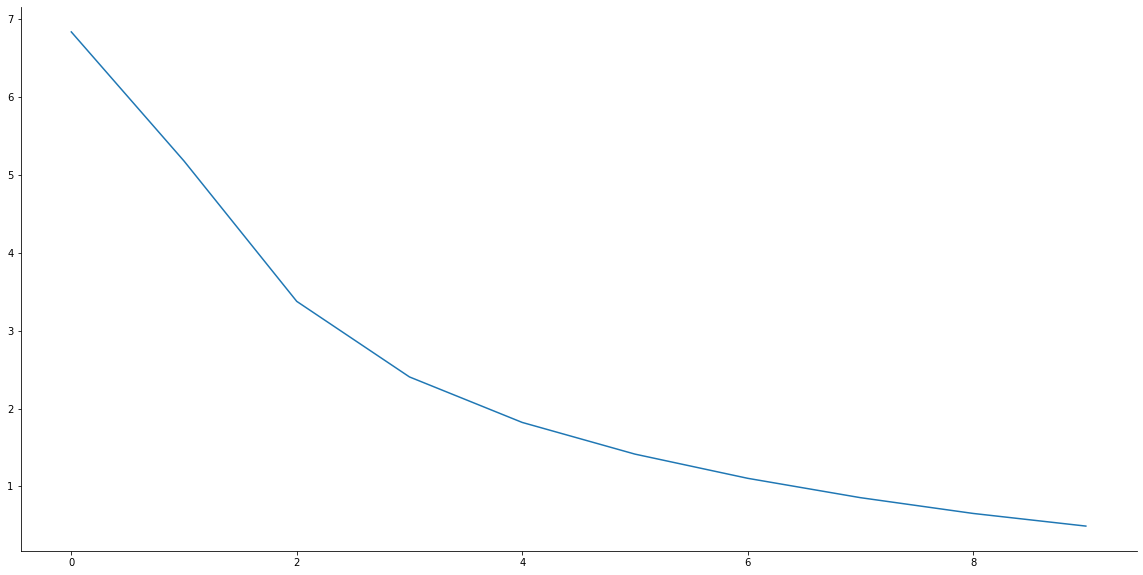

In [33]:
plt.figure(figsize=(20,10))
seaborn.lineplot(x=range(len(historical_loss_test_hip)), y=historical_loss_test_hip)
seaborn.despine()

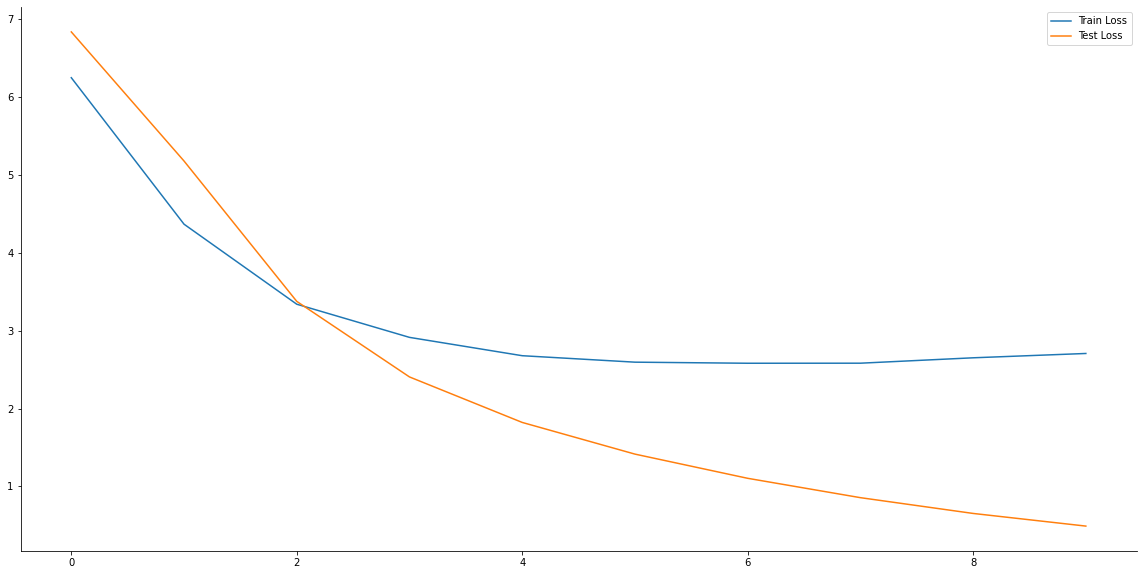

In [34]:
plt.figure(figsize=(20,10))
seaborn.lineplot(x=range(len(historical_loss_train_hip)), y=historical_loss_train_hip, label='Train Loss')
seaborn.lineplot(x=range(len(historical_loss_train_hip)), y=historical_loss_test_hip, label='Test Loss')
plt.legend()
seaborn.despine()

#### Comparación de redes

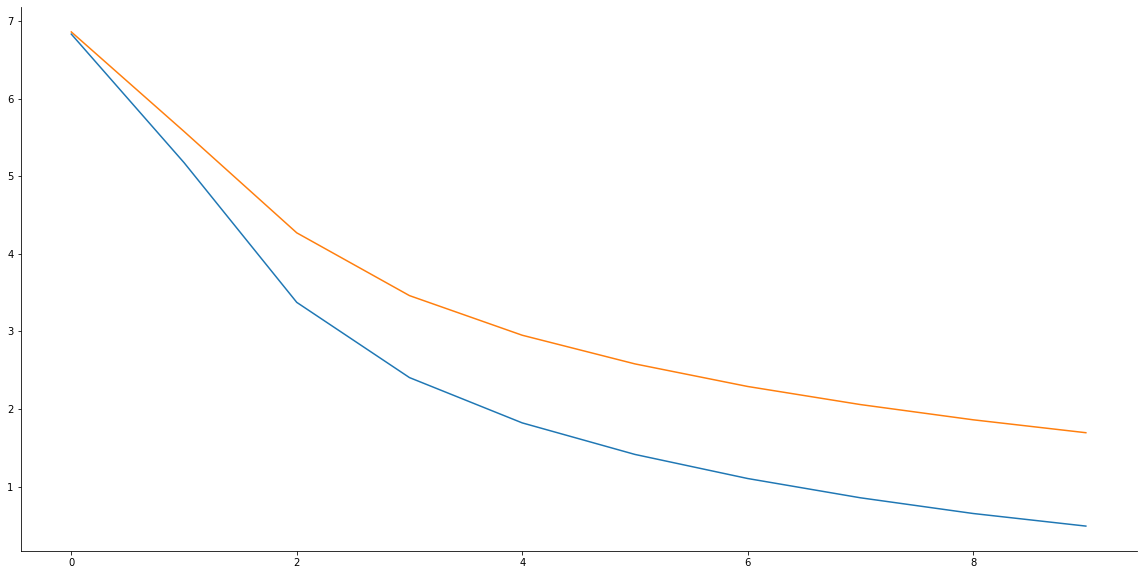

In [35]:
plt.figure(figsize=(20,10))
seaborn.lineplot(x=range(len(historical_loss_test_hip)), y=historical_loss_test_hip)
seaborn.lineplot(x=range(len(historical_loss_test)), y=historical_loss_test)
seaborn.despine()

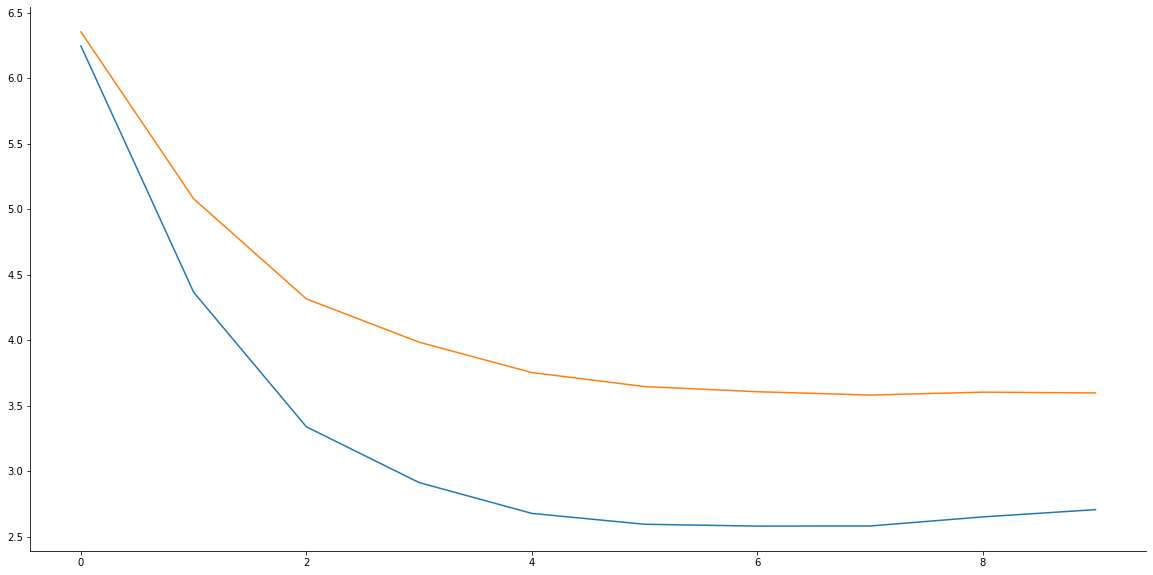

In [36]:
plt.figure(figsize=(20,10))
seaborn.lineplot(x=range(len(historical_loss_train_hip)), y=historical_loss_train_hip)
seaborn.lineplot(x=range(len(historical_loss_train)), y=historical_loss_train)
seaborn.despine()

In [37]:
print("Balanced accuracy con hiperparáemtros:", balanced_accuracy_hip, 
      "\n Balanced accuracy sin hiperparáemtros:", balanced_accuracy)

Balanced accuracy con hiperparáemtros: [0.5030761183786118] 
 Balanced accuracy sin hiperparáemtros: [0.3419090804659704]


A modo de ejemplo en este código se filtraron solo 100.000 registros del dataset original, pero se adjuntan como evidencia los resultados originados para el dataset entero para la red con hiperparámetros por default y para la red con optimización manual de hiperparámetros.
A simple viste al comparar ambas redes en el sample de 100.000 registros observamos que la red con los parámetros por default obtiene mejores resultados que la red con hiperparámetros que elegimos manualmente. Por ejemplo el balanced_Accuracy en la red con hiperparámetros es de 0.5030 mientras que para la red con los parámetros por default este valor es 0.3419